In [1]:
#import
import numpy as np
import os
import pandas as pd
import datetime
from scipy import stats
import matplotlib.pyplot as plot
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tqdm import tqdm
import pickle


In [2]:
def shiftedColorMap_single(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.

    https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib (Paul H., Dec 11, 2013)
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    # pyplot.register_cmap(cmap=newcmap)

    return newcmap

K2: 0


C:\Users\wunsc\AppData\Local\Temp\ipykernel_4324\250565577.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(templabel,fontsize=12)
C:\Users\wunsc\AppData\Local\Temp\ipykernel_4324\250565577.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(templabel,fontsize=12)
C:\Users\wunsc\AppData\Local\Temp\ipykernel_4324\250565577.py:186: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(templabel,fontsize=12)
C:\Users\wunsc\AppData\Local\Temp\ipykernel_4324\250565577.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(templabel,fontsize=12)
C:\Users\wunsc\AppData\Local\Temp\ipykernel_4324\250565577.py:207: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(templabel,fontsize=12)
C:\Users\wunsc\AppData\Local\Temp\ipykernel_4324\250565577.py:209

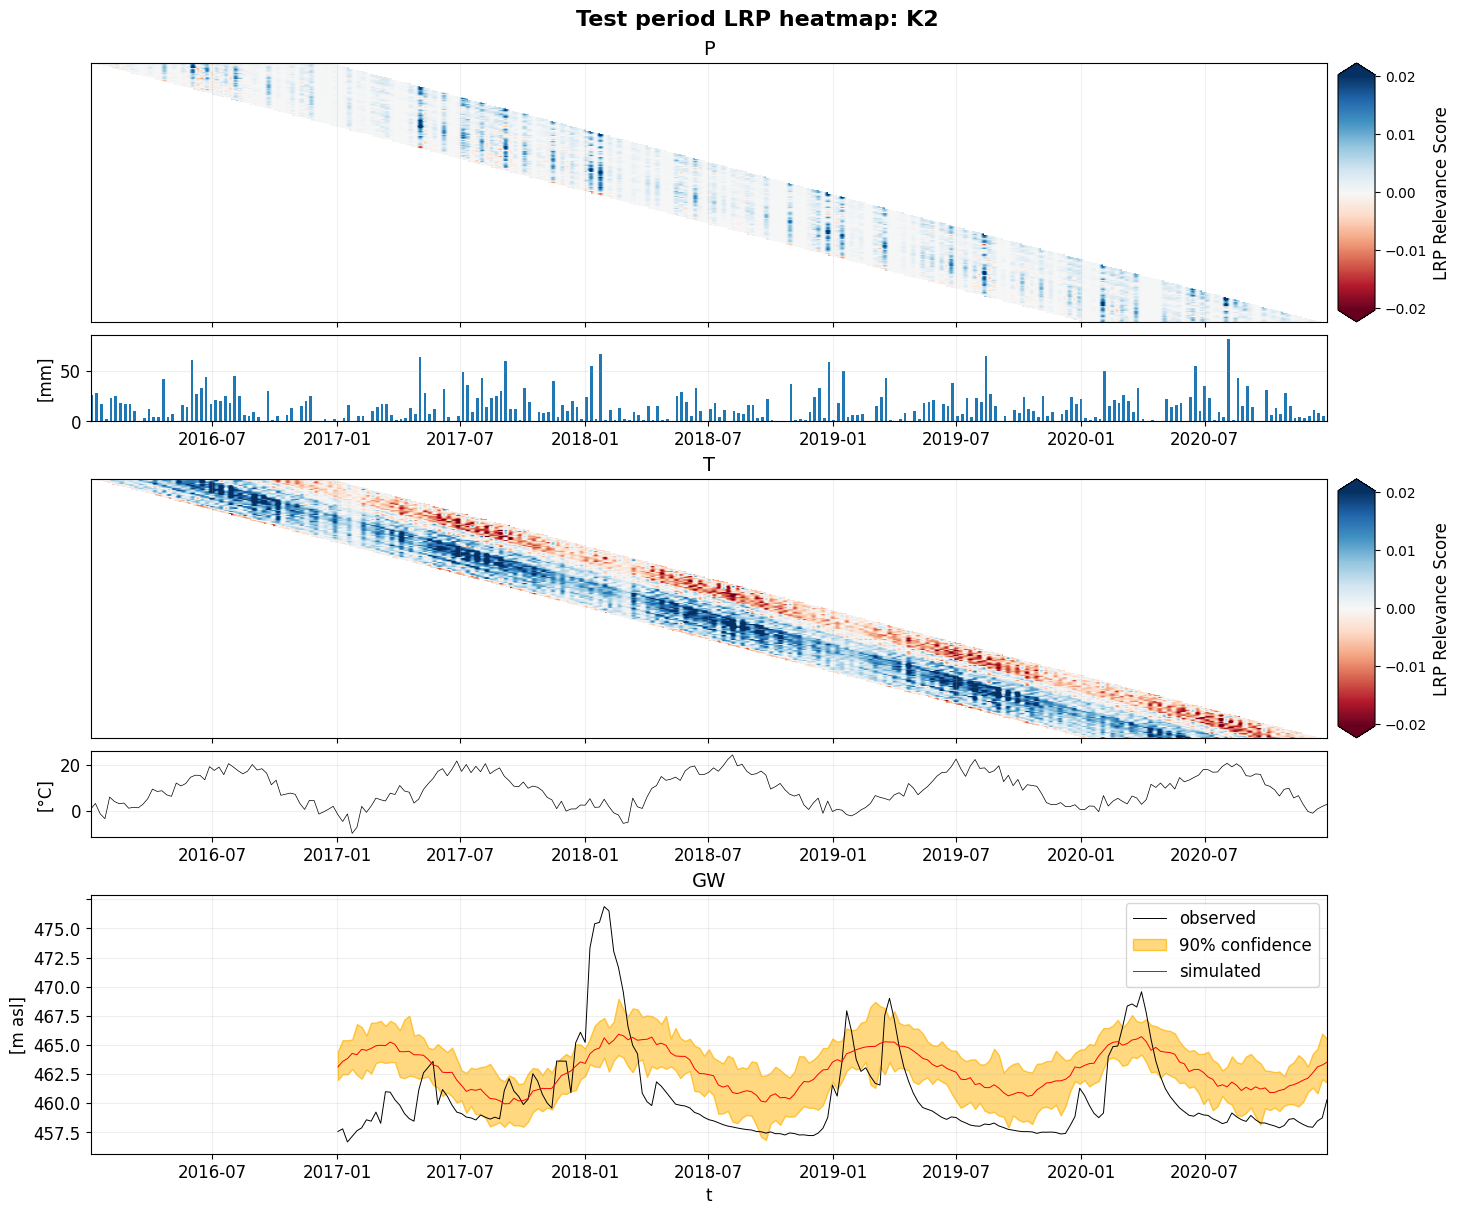

In [6]:

well_list = pd.read_csv("./locations.csv",sep=';',header = 0,encoding = 'Latin1')

for loc in [0]:#range(well_list.shape[0]):
   
    ID = well_list.alias[loc]
    print(ID+": "+str(loc))
    
    method = 'lrp.z'
    file = './Results_XAI/analysis_'+ID+'_'+method.replace('.','')+'.pickle'
    
    with open(file, 'rb') as f:
        imports = pickle.load(f)
    
    analysis = imports['analysis_mean']
    data_investigate = imports['data_investigate']
    data_investigate_ext = imports['data_investigate_ext']
    
    seqlength = 52
    y_list = imports['simulations']
    sim_members = np.zeros(shape = (y_list[0].shape[0],20))
    for i in range(20):
        sim_members[:,i] = y_list[i].reshape(-1,)
    sim_mean = np.nanmean(sim_members,axis = 1)
    sim_uncertainty = [np.quantile(sim_members, 0.05, axis=1),np.quantile(sim_members, 0.95, axis=1)]
    
    #%% imshow shifted, full time series

    analysis_reshaped = np.zeros(shape=(data_investigate.shape[0],data_investigate.shape[0]+seqlength,2))
    analysis_reshaped[:]=np.nan
    
    for i in range(data_investigate.shape[0]):
        analysis_reshaped[i,i:i+seqlength,0] = analysis[i,:,0]
        analysis_reshaped[i,i:i+seqlength,1] = analysis[i,:,1]

    titles=['P','T']
    date_format = matplotlib.dates.DateFormatter('')
    x_lims = [data_investigate_ext.index[0],data_investigate_ext.index[-1]]
    x_lims = matplotlib.dates.date2num(x_lims)
    y_lims = [analysis_reshaped.shape[0]-0.5, -0.5]
    
    
    # fig = plot.figure(constrained_layout=True,figsize=(15,12))
    
    # gs = fig.add_gridspec(11, 1)
    # ax0 = fig.add_subplot(gs[0:3, 0]) #P analysis
    # ax1 = fig.add_subplot(gs[3, 0]) # P inputs
    # ax2 = fig.add_subplot(gs[4:7, 0]) # T analysis
    # ax3 = fig.add_subplot(gs[7, 0]) # T inputs
    # ax4 = fig.add_subplot(gs[8:11, 0]) # GWL
    
    # vmin = -3*np.nanstd(analysis.squeeze())#np.nanmin(analysis.squeeze())
    # vmax = 3*np.nanstd(analysis.squeeze())#np.nanmax(analysis.squeeze())
    # cmap = matplotlib.cm.get_cmap('RdBu')
    # # cmap = matplotlib.cm.get_cmap("seismic_r")
    # mid = 1 - vmax / (vmax + abs(vmin))
    # cmap1 = shiftedColorMap_single(cmap, midpoint=mid, name='shifted')
        
    # im = ax0.imshow(analysis_reshaped[:,:,0],aspect='auto',cmap=cmap1,vmin = vmin, vmax = vmax,extent=[x_lims[0],x_lims[1],y_lims[0],y_lims[1]])
    # ax0.xaxis_date()
    # ax0.xaxis.set_major_formatter(date_format)
    # ax0.grid(alpha=0.2)
    # ax0.set_title(titles[0])
    # ax0.set_yticks([])
    # cbar = fig.colorbar(im, ax=ax0,aspect=7, anchor=(5,0.5), extend='both')
    # cbar.set_label(label="LRP Relevance Score",rotation=90)
    
    # ax1.bar(data_investigate_ext.index,data_investigate_ext['P'],width=4,align='edge')
    # ax1.set_xlim([data_investigate_ext.index[0],data_investigate_ext.index[-1]])
    # ax1.grid(alpha=0.2)
    # ax1.set_ylabel('[mm]')
    
    # im = ax2.imshow(analysis_reshaped[:,:,1],aspect='auto',cmap=cmap1,vmin = vmin, vmax = vmax,extent=[x_lims[0],x_lims[1],y_lims[0],y_lims[1]])
    # ax2.xaxis_date()
    # ax2.xaxis.set_major_formatter(date_format)
    # ax2.grid(alpha=0.2)
    # ax2.set_title(titles[1])
    # # ax2.set_xticks([])
    # ax2.set_yticks([])
    # cbar = fig.colorbar(im, ax=ax2,aspect=7, anchor=(5,0.5), extend='both')
    # cbar.set_label(label="LRP Relevance Score",rotation=90)
    
    # ax3.plot(data_investigate_ext.index,data_investigate_ext['T'],color='k',linewidth=0.5)
    # ax3.set_xlim([data_investigate_ext.index[0],data_investigate_ext.index[-1]])
    # ax3.grid(alpha=0.2)
    # ax3.set_ylabel('[°C]')
    
    # ax4.plot(data_investigate.index,data_investigate.GWL,color='k',label='observed',linewidth=0.7)
    # ax4.set_xlim([data_investigate_ext.index[0],data_investigate.index[-1]])
    # ax4.set_title('GW')
    # lb = sim_uncertainty[0]
    # ub = sim_uncertainty[1]
    # ax4.fill_between(data_investigate.index, lb,
    #             ub, facecolor = (1,0.7,0,0.5),
    #             label ='90% confidence',linewidth = 1,
    #             edgecolor = (1,0.7,0,0.7))
    # ax4.plot(data_investigate.index,sim_mean,color='r',label='simulated',linewidth=0.7)
    
    # ax4.grid(alpha=0.2)
    # ax4.set_ylabel('[m asl]')
    # ax4.set_xlabel('t')
    # ax4.legend(fontsize=12)
    
    # # ax_grid = fig.add_subplot(111, zorder=-1)
    # # for _, spine in ax_grid.spines.items():
    # #     spine.set_visible(False)
    # # ax_grid.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
    # # ax_grid.get_shared_x_axes().join(ax_grid,ax4)
    # # ax_grid.grid(axis="x")

    
    
    # fig.suptitle(ID, fontsize=16)
    # # plot.savefig('./heatmaps/'+ID+'_full_length.png',dpi=600,bbox_inches='tight')
    # plot.rc("pdf", fonttype=42)
    # plot.savefig('./heatmaps/'+ID+'_full_length.png',dpi=600,bbox_inches='tight')
    # plot.show()
    
    #%% imshow shifted, section
    import datetime as dt
    start = dt.datetime(2017,1,1)
    end =dt.datetime(2020,12,31)
    
    
    if end > data_investigate.index[-1]:
        end = data_investigate.index[-1]
        
    idx = np.logical_and(data_investigate.index >= start,
                            data_investigate.index <= end)
    idx2 = np.logical_and(data_investigate_ext.index >= start-dt.timedelta(weeks = seqlength),
                            data_investigate_ext.index <= end) 
    analysis_ = analysis[idx,:,:]
    data_investigate_ = data_investigate.iloc[idx,:]
    data_investigate_ext_ = data_investigate_ext.iloc[idx2,:]
    sim_mean_ = sim_mean[idx]
    analysis_reshaped_ = np.zeros(shape=(data_investigate_.shape[0],data_investigate_.shape[0]+seqlength,2))
    analysis_reshaped_[:]=np.nan
    for i in range(data_investigate_.shape[0]):
        analysis_reshaped_[i,i:i+seqlength,0] = analysis_[i,:,0]
        analysis_reshaped_[i,i:i+seqlength,1] = analysis_[i,:,1]
    

    titles=['P','T']
    date_format = matplotlib.dates.DateFormatter('')
    x_lims = [data_investigate_ext_.index[0],data_investigate_ext_.index[-1]]
    x_lims = matplotlib.dates.date2num(x_lims)
    y_lims = [analysis_reshaped.shape[0]-0.5, -0.5]
    
    fig = plot.figure(constrained_layout=True,figsize=(15,12))
    
    gs = fig.add_gridspec(11, 1)
    ax0 = fig.add_subplot(gs[0:3, 0]) #P analysis
    ax1 = fig.add_subplot(gs[3, 0]) # P inputs
    ax2 = fig.add_subplot(gs[4:7, 0]) # T analysis
    ax3 = fig.add_subplot(gs[7, 0]) # T inputs
    ax4 = fig.add_subplot(gs[8:11, 0]) # GWL
    
    vmin = -3*np.nanstd(analysis_.squeeze())#np.nanmin(analysis_.squeeze())
    vmax = 3*np.nanstd(analysis_.squeeze())#np.nanmax(analysis_.squeeze())
    cmap = matplotlib.cm.get_cmap('RdBu')
    # cmap = matplotlib.cm.get_cmap("seismic_r")
    mid = 1 - vmax / (vmax + abs(vmin))
    cmap1 = shiftedColorMap_single(cmap, midpoint=mid, name='shifted')
        
    
    im = ax0.imshow(analysis_reshaped_[:,:,0],aspect='auto',cmap=cmap1,vmin = vmin, vmax = vmax,extent=[x_lims[0],x_lims[1],y_lims[0],y_lims[1]])
    ax0.xaxis_date()
    ax0.xaxis.set_major_formatter(date_format)
    ax0.grid(alpha=0.2)
    ax0.set_title(titles[0],fontsize=14)
    ax0.set_yticks([])
    cbar = fig.colorbar(im, ax=ax0,aspect=7, anchor=(5,0.5), extend='both')
    cbar.set_label(label="LRP Relevance Score",rotation=90,fontsize=12)
    templabel=ax0.get_yticklabels()
    ax0.set_yticklabels(templabel,fontsize=12)
    templabel=ax0.get_xticklabels()
    ax0.set_xticklabels(templabel,fontsize=12)
    
    
    ax1.bar(data_investigate_ext_.index,data_investigate_ext_['P'],width=4,align='edge')
    ax1.set_xlim([data_investigate_ext_.index[0],data_investigate_ext_.index[-1]])
    ax1.grid(alpha=0.2)
    ax1.set_ylabel('[mm]',fontsize=12)
    templabel=ax1.get_yticklabels()
    ax1.set_yticklabels(templabel,fontsize=12)
    templabel=ax1.get_xticklabels()
    ax1.set_xticklabels(templabel,fontsize=12)
    
    im = ax2.imshow(analysis_reshaped_[:,:,1],aspect='auto',cmap=cmap1,vmin = vmin, vmax = vmax,extent=[x_lims[0],x_lims[1],y_lims[0],y_lims[1]])
    ax2.xaxis_date()
    ax2.xaxis.set_major_formatter(date_format)
    ax2.grid(alpha=0.2)
    ax2.set_title(titles[1],fontsize=14)
    ax2.set_yticks([])
    cbar = fig.colorbar(im, ax=ax2,aspect=7, anchor=(5,0.5), extend='both')
    cbar.set_label(label="LRP Relevance Score",rotation=90,fontsize=12)
    templabel=ax2.get_yticklabels()
    ax2.set_yticklabels(templabel,fontsize=12)
    templabel=ax2.get_xticklabels()
    ax2.set_xticklabels(templabel,fontsize=12)
    
    
    ax3.plot(data_investigate_ext_.index,data_investigate_ext_['T'],color='k',linewidth=0.5)
    ax3.set_xlim([data_investigate_ext_.index[0],data_investigate_ext_.index[-1]])
    ax3.grid(alpha=0.2)
    ax3.set_ylabel('[°C]',fontsize=12)
    templabel=ax3.get_yticklabels()
    ax3.set_yticklabels(templabel,fontsize=12)
    templabel=ax3.get_xticklabels()
    ax3.set_xticklabels(templabel,fontsize=12)
    
    ax4.plot(data_investigate_.index,data_investigate_.GWL,color='k',label='observed',linewidth=0.7)
    ax4.set_xlim([data_investigate_ext_.index[0],data_investigate_.index[-1]])
    ax4.set_title('GW',fontsize=14)
    lb = sim_uncertainty[0][idx]
    ub = sim_uncertainty[1][idx]
    ax4.fill_between(data_investigate_.index, lb,
                ub, facecolor = (1,0.7,0,0.5),
                label ='90% confidence',linewidth = 1,
                edgecolor = (1,0.7,0,0.7))
    ax4.plot(data_investigate_.index,sim_mean_,color='r',label='simulated',linewidth=0.7)
    
    ax4.grid(alpha=0.2)
    ax4.set_ylabel('[m asl]',fontsize=12)
    ax4.set_xlabel('t',fontsize=12)
    ax4.legend(fontsize=12)
    templabel=ax4.get_yticklabels()
    ax4.set_yticklabels(templabel,fontsize=12)
    templabel=ax4.get_xticklabels()
    ax4.set_xticklabels(templabel,fontsize=12)
    
    fig.suptitle('Test period LRP heatmap: '+ID, fontsize=16,fontweight='bold')
    # plot.savefig('./heatmaps/'+ID+'_from_'+str(start)[:10]+'_to_'+str(end)[:10]+'.png',dpi=600,bbox_inches='tight')
    plot.rc("pdf", fonttype=42)
    plot.savefig('./Results_XAI/heatmaps/'+ID+'_from_'+str(start)[:10]+'_to_'+str(end)[:10]+'.png',dpi=600,bbox_inches='tight')
    plot.show()
    
    